# Exam exercise!

## Time transients

Time transients appear in many many physical applications. Electromagnetic signals, electronics readouts, or in astronomy things like exploding stars, gravitational waves, etc etc etc.

An instrument (say a microphone) is taking data and there's some background noise. Then at some point a signal appears. The features of the signals contain precious information (which rock band is playing, the details of the exploding star).


(Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!)


### Tasks

1) Read in `datasets/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the intensity of the signal (arbitrary units), and the third column are measurement uncertainties on the latter. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code up this burst model, and code a likelihood function for this data with the burst model.

3) Using one of the MCMC sampler that we looked at in class, perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

8) Another possible model that may explain the data is a Gaussian profile.

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

 Fit this model usign an MCMC and reasonable priors (this time is up to you to decide...)

9) Now.. is that transient an exponential pulse or a gaussian? What do you think? We need to quantify it... and that's going to be the goal of the next two lectures! So stay tuned.



### Results... 

This exercise was much harder than the previous ones (yep, I know), so here is the result so you can check what you have makes sense. This is not a unique answer! If you made different choices that's ok.  

This is my stationary chain (the trace plot)...

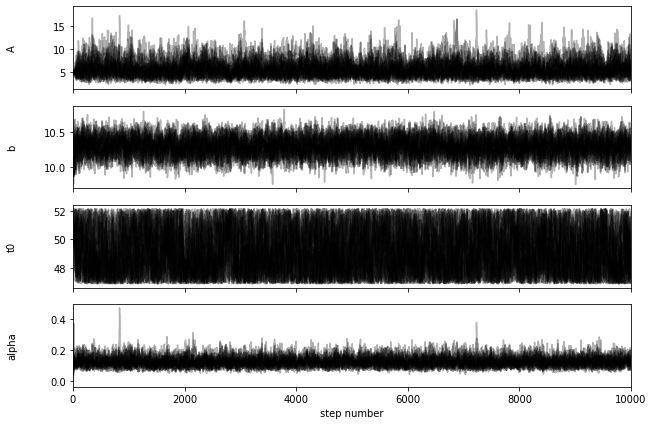

... and this is my corner plot

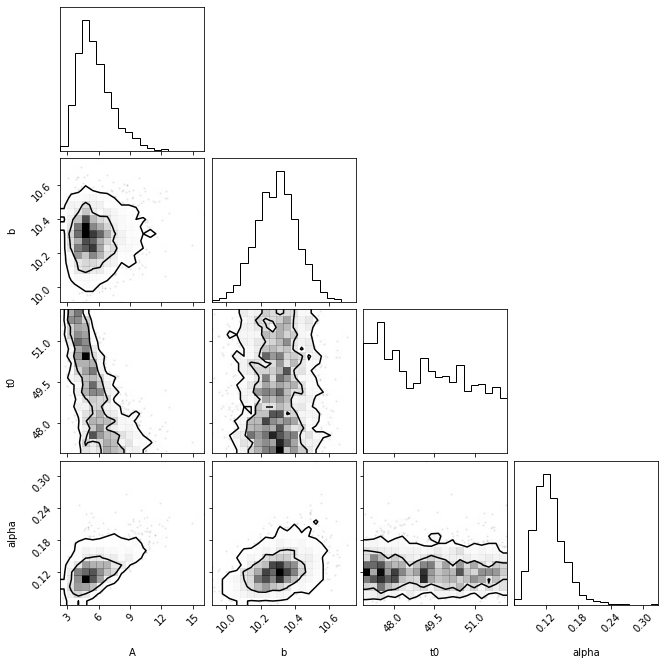


#### Task 1: Plotting the data

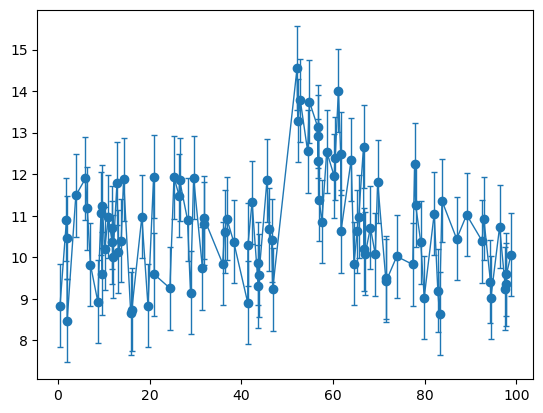

In [1]:
import matplotlib.pyplot as plt
import numpy as np

tt_array = np.load("datasets/transient.npy")

plt.errorbar(tt_array[..., 0], tt_array[...,1], tt_array[...,2], marker='o', linewidth=1, capsize=2)
plt.show()

#### Task 2: Burst Model
Since we'll be using PyMC, we cannot use numpy: we must use pytensor.

In [2]:
import pytensor.tensor as pt

def burst_model(x, x_0, background_amp, burst_amp, alpha, numpy=False):
    if numpy:
        return np.where(
            x < x_0,
            background_amp,
            background_amp + burst_amp * np.exp(-alpha * (x - x_0))
        )
    return pt.switch(
        pt.lt(x, x_0),
        background_amp,
        background_amp + burst_amp * pt.math.exp(-alpha * (x - x_0))
    )

# def burst_log_likelihood(theta, x, y, yerr):
#     x_0, background_amp, burst_amp, alpha = theta
#     model = burst_model(x, x_0, background_amp, burst_amp, alpha)
#     return -0.5 * at.sum(((y - model) / yerr) ** 2)

# PyMC handles the log likelihood internally, so we don't need to define it explicitly.

#### Task 3: MCMC Sampling - Using PyMC

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b, A, ln_alpha]
>Metropolis: [t0]


Output()

Sampling 4 chains for 2_000 tune and 15_000 draw iterations (8_000 + 60_000 draws total) took 66 seconds.


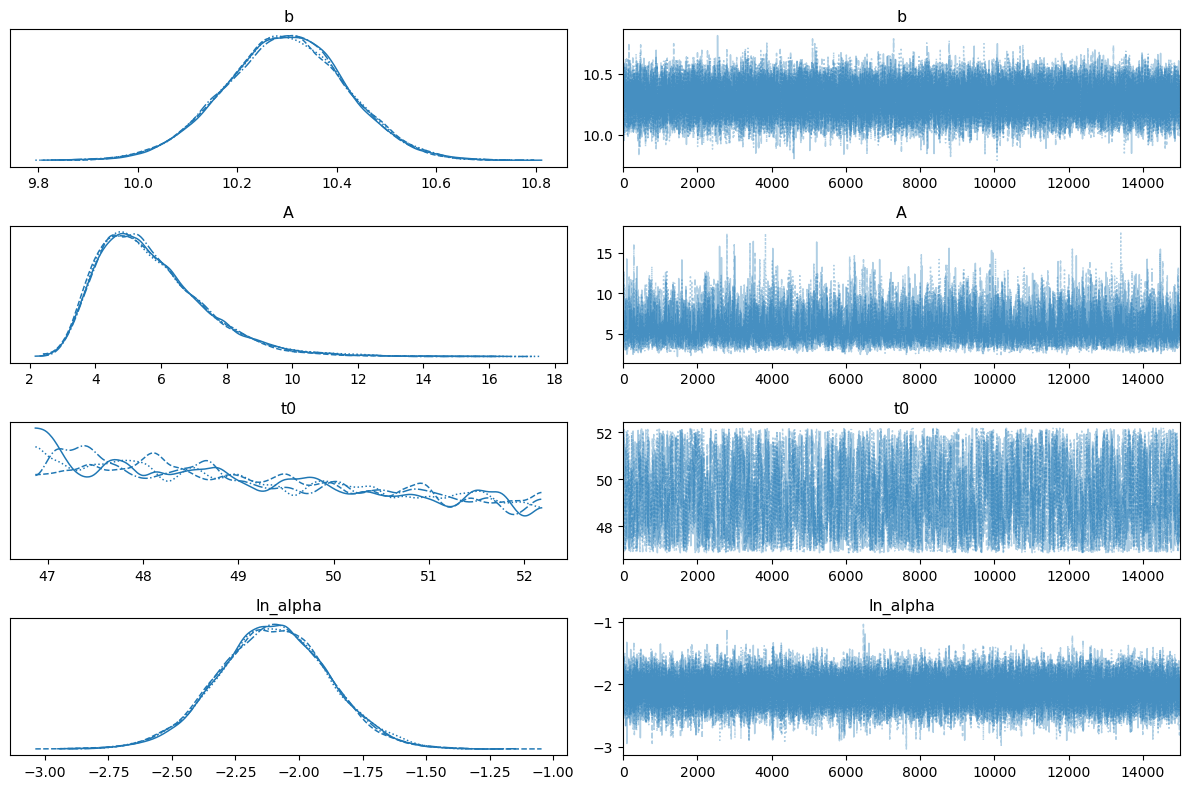

In [16]:
import pymc as pm
import arviz as az

t_values = tt_array[..., 0]
y_values = tt_array[..., 1]
y_errs = tt_array[:, 2]


with pm.Model() as model:
    t = pm.Data("t", t_values)
    y = pm.Data("y", y_values)
    y_errs = pm.Data("y_errs", y_errs)

    # Priors
    b = pm.Uniform("b", lower=0, upper=50)
    A = pm.Uniform("A", lower=0, upper=50)
    t0 = pm.Uniform("t0", lower=0, upper=100)
    ln_alpha = pm.Uniform("ln_alpha", lower=-5, upper=5)
    alpha = pm.math.exp(ln_alpha)

    # Deterministic
    y_model = burst_model(t, t0, b, A, alpha)
    
    # Likelihood
    y_obs = pm.Normal("y_obs", mu=y_model, sigma=y_errs, observed=y)


    nuts_kernel = pm.NUTS(vars=[b, A, ln_alpha], target_accept=0.95)
    metro_kernel = pm.Metropolis(vars=[t0]) # t0 has a hard threshold, for NUTS it must be differentiable, which it is not

    trace = pm.sample(draws=15000, tune=2000, step=[nuts_kernel, metro_kernel], return_inferencedata=True)


az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [4]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,10.30,0.12,10.07,10.53,0.00,0.00,25518.49,25646.47,1.0
A,5.72,1.69,3.06,8.83,0.03,0.02,3031.79,11369.73,1.0
t0,49.23,1.54,46.87,51.77,0.04,0.01,1945.63,4105.47,1.0
ln_alpha,-2.10,0.22,-2.52,-1.69,0.00,0.00,24633.99,26737.56,1.0


In [ ]:
post_b = trace.posterior.b.mean().item()
post_A = trace.posterior.A.mean().item()
post_t0 = trace.posterior.t0.mean().item()
post_lnalpha = trace.posterior.ln_alpha.mean().item()
post_alpha = np.exp(post_lnalpha)

print(post_b, post_A, post_t0, post_alpha)

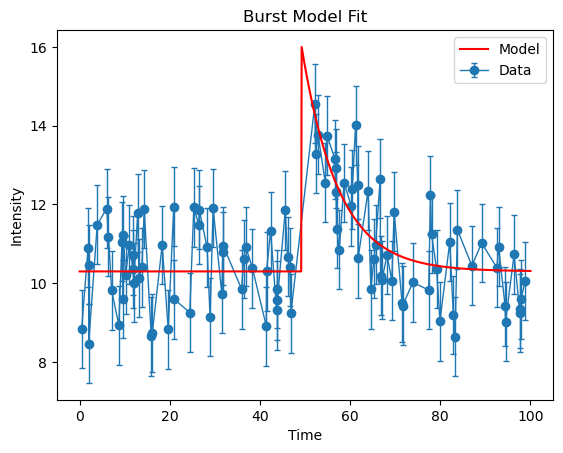

In [62]:
x = np.linspace(0, 100, 1000)
y = burst_model(x, post_t0, post_b, post_A, post_alpha, numpy=True)
plt.plot(x, y, label="Model", color="red", zorder=3)
plt.errorbar(tt_array[..., 0], tt_array[..., 1], tt_array[..., 2], marker='o', linewidth=1, capsize=2, label="Data")
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.title("Burst Model Fit")
plt.legend()
plt.show()

#### Task 4: Burn-in & thin by autocorrelation
Burn-in is automatically performed by PyMC, since the default value for `discard_tuned_samples` is `True`.

Autocorrelation is easily obtained in emcee, but not in our case. Instead, we seek to exploit ESS to get the tau value.

In [63]:
nchains = trace.posterior.chain.size
ndraws = trace.posterior.draw.size
Ntot = nchains * ndraws

ess = az.ess(trace)  # xarray with dim "variable"
ess

<xarray.Dataset> Size: 32B
Dimensions:   ()
Data variables:
    b         float64 8B 2.661e+04
    A         float64 8B 3.525e+03
    t0        float64 8B 2.062e+03
    ln_alpha  float64 8B 2.482e+04

In [64]:
tau_ests = {var: Ntot / ess[var] 
           for var in ess.data_vars}
tau_ests

{'b': <xarray.DataArray 'b' ()> Size: 8B
 array(2.25517475),
 'A': <xarray.DataArray 'A' ()> Size: 8B
 array(17.02054645),
 't0': <xarray.DataArray 't0' ()> Size: 8B
 array(29.10158768),
 'ln_alpha': <xarray.DataArray 'ln_alpha' ()> Size: 8B
 array(2.41757741)}

In [65]:
thin = int(max(tau_ests.values()))

thinned = trace.isel(draw=slice(None, None, thin))

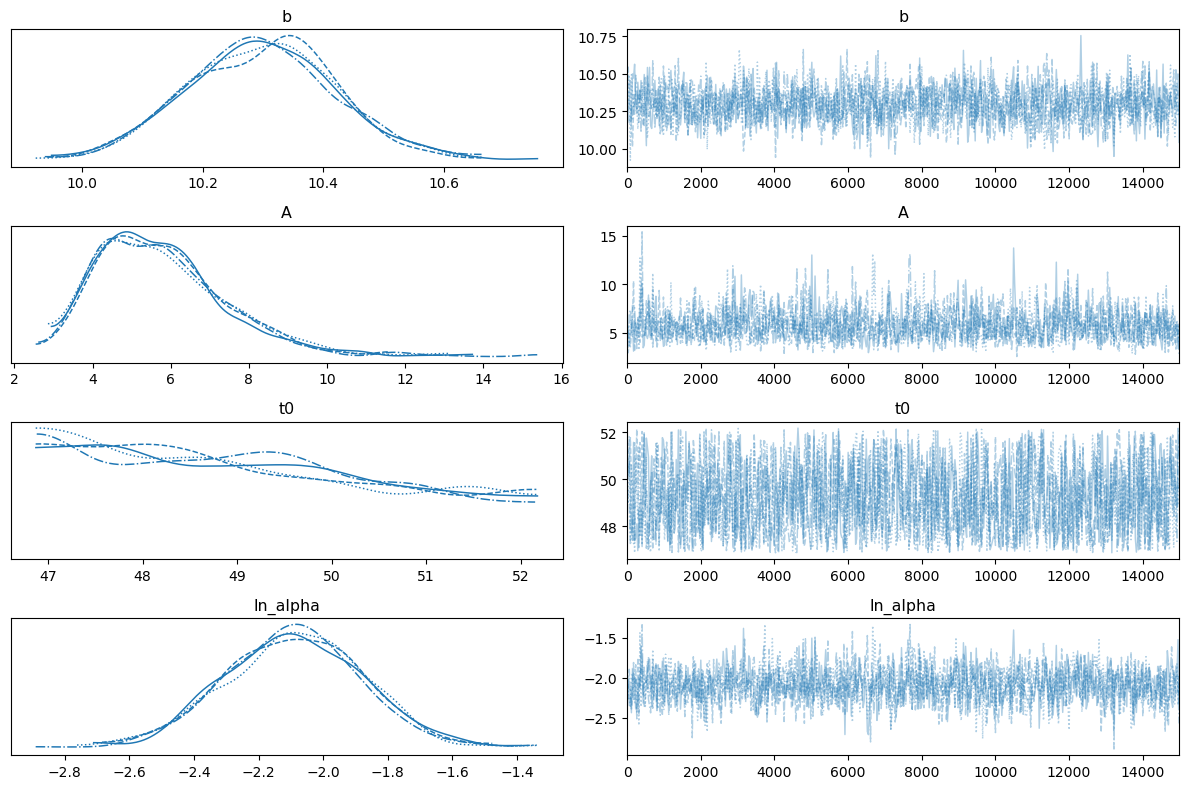

In [66]:
az.plot_trace(thinned)
plt.tight_layout()
plt.show()

#### Task 5: Corner plot

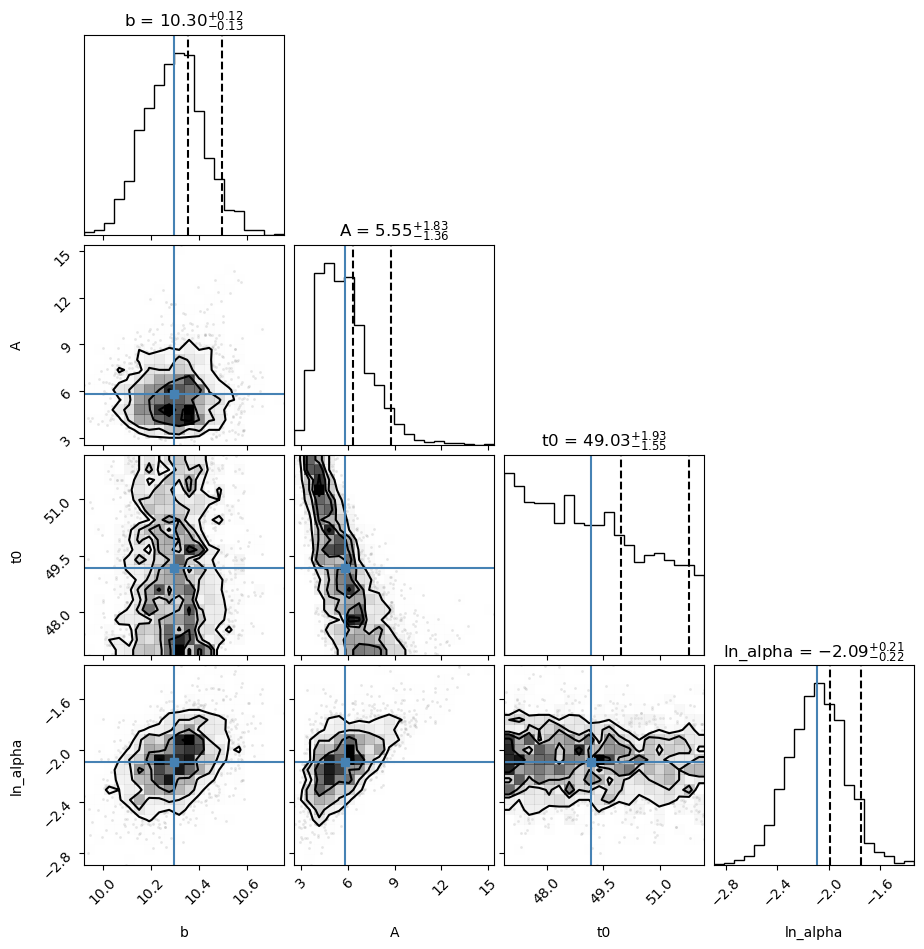

In [67]:
import corner

b = thinned.posterior["b"].values.flatten()
A = thinned.posterior["A"].values.flatten()
t0 = thinned.posterior["t0"].values.flatten()
ln_alpha = thinned.posterior["ln_alpha"].values.flatten()

fig = corner.corner(
    np.array([b, A, t0, ln_alpha]).T,
    labels=["b", "A", "t0", "ln_alpha"],
    truths=[np.mean(b), np.mean(A), np.mean(t0), np.mean(ln_alpha)],
    quantiles=[0.68, 0.95],
    title_quantiles=[0.16, 0.50, 0.84], # for 68% CI
    show_titles=True,
    title_kwargs={"fontsize": 12},
)
plt.show()

#### Task 6: 100 random samples

In [68]:
import numpy as np

def generate_burst(t, x_0, background_amp, burst_amp, alpha):
    """Generate burst time-series with numpy arrays."""
    burst = np.where(
        t < x_0,
        background_amp,
        background_amp + burst_amp * np.exp(-alpha * (t - x_0))
    )
    return burst

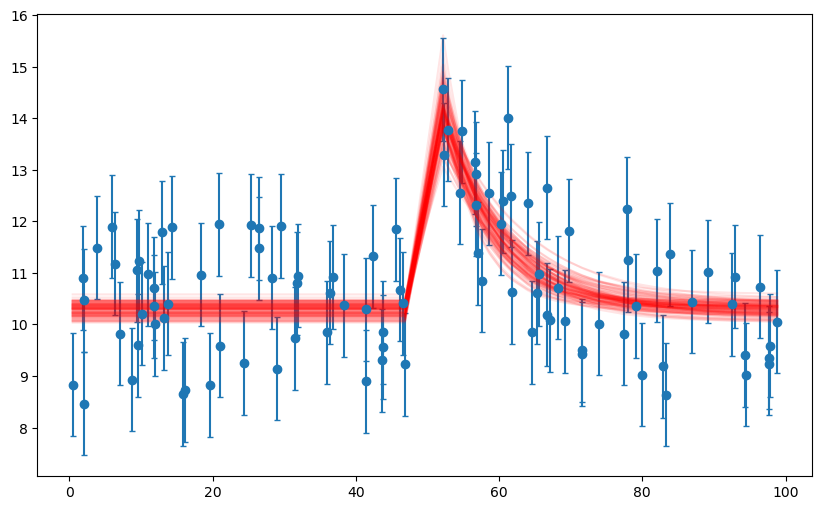

In [69]:
flat_samples = thinned.posterior.stack(draws=("chain", "draw"))

t = t_values
original_y = y_values

n_draws = 100
indices = np.random.choice(flat_samples.draws.size, size=n_draws, replace=False)

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(tt_array[..., 0], tt_array[...,1], tt_array[...,2], marker='o', capsize=2, linestyle='None')

for i in indices:
    # Extract parameter values
    b = flat_samples["b"].values[i]
    A = flat_samples["A"].values[i]
    t0 = flat_samples["t0"].values[i]
    alpha = np.exp(flat_samples["ln_alpha"].values[i])

    # Generate burst curve
    burst_curve = generate_burst(t, t0, b, A, alpha)
    ax.plot(t, burst_curve, color="red", alpha=0.1)



#### Task 7: Credible region 90%

In [70]:
from IPython.display import display, Latex

def summarize_param(param_values, transform=None):
    if transform:
        param_values = transform(param_values)
        
    median = np.percentile(param_values, 50)
    lower = np.percentile(param_values, 5)
    upper = np.percentile(param_values, 95)
    
    plus = upper - median
    minus = median - lower
    
    return median, plus, minus

params = {
    "t_0": flat_samples["t0"].values,
    "b": flat_samples["b"].values,
    "A": flat_samples["A"].values,
    r"\alpha": flat_samples["ln_alpha"].values,  # ln_alpha needs transformation
}

params[r"\alpha"] = np.exp(params[r"\alpha"])

for name, values in params.items():
    median, plus, minus = summarize_param(values)
    latex_str = fr"${name} = {median:.3f}^{{+{plus:.3f}}}_{{-{minus:.3f}}}$"
    display(Latex(latex_str))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Task 8: Gaussian?

In [71]:
def gaussian_graph(x, x_0, background_amp, burst_amp, sigma):
    return background_amp + burst_amp * np.exp(-((x - x_0)**2 / 2 * sigma**2))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, A, t0, sigma]


Output()

Sampling 4 chains for 2_000 tune and 15_000 draw iterations (8_000 + 60_000 draws total) took 23 seconds.


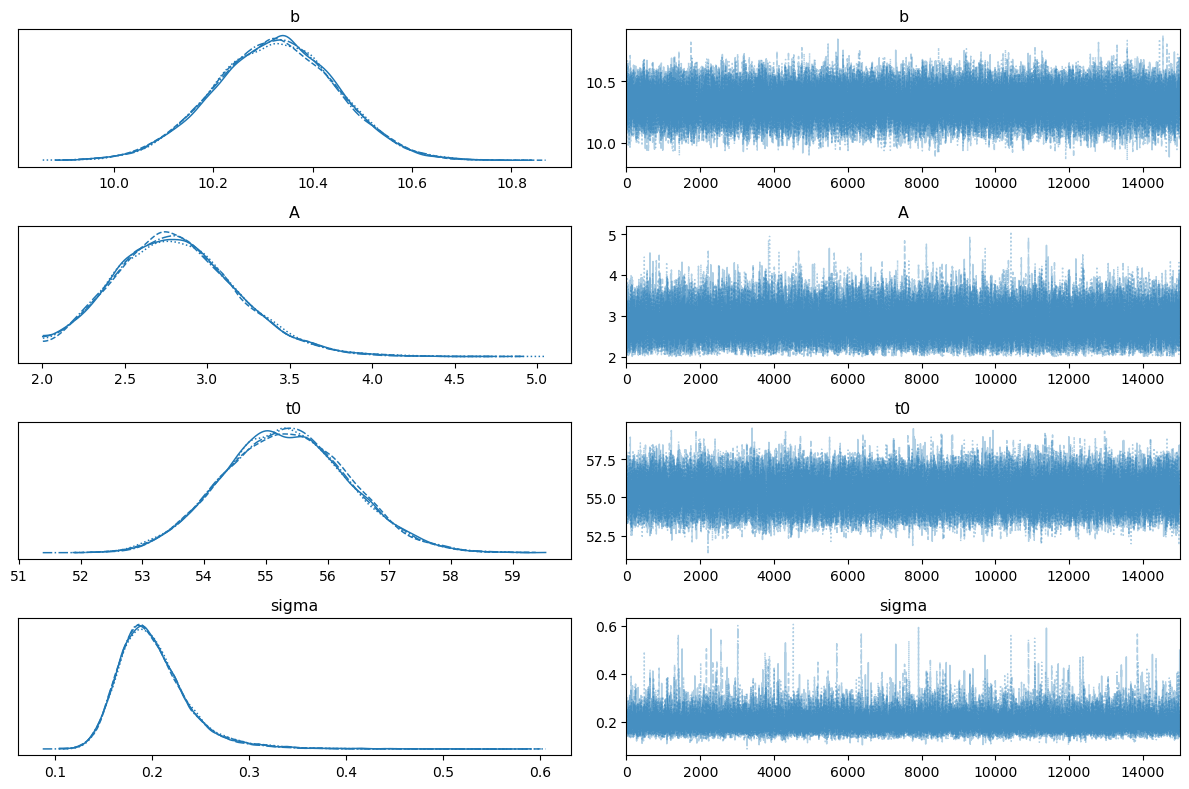

In [ ]:
t_values = tt_array[..., 0]
y_values = tt_array[..., 1]
y_errs = tt_array[:, 2]

with pm.Model() as model:
    t = pm.Data("t", t_values)
    y = pm.Data("y", y_values)
    y_errs = pm.Data("y_errs", y_errs)

    # Priors
    b = pm.Uniform("b", lower=0, upper=20) # In the data, we see that the baseline is around 10
    A = pm.Uniform("A", lower=2, upper=6) # If we assume 10 as baseline, the peak should be at around 4 (which is 14 in the data)
    t0 = pm.Uniform("t0", lower=30, upper=80) # In the data, we see that the peak is around t=50
    sigma = pm.Uniform("sigma", lower=0, upper=5)
    
    # Deterministic
    y_model = gaussian_graph(t, t0, b, A, sigma)
    # Likelihood
    y_obs = pm.Normal("y_obs", mu=y_model, sigma=y_errs, observed=y)

    # We can use NUTS for all parameters: Gaussian is differentiable across the whole space
    trace = pm.sample(draws=15000, tune=2000, target_accept=0.95, return_inferencedata=True)

az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [77]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,10.32,0.12,10.09,10.55,0.00,0.0,33429.50,36564.15,1.0
A,2.81,0.38,2.08,3.48,0.00,0.0,29504.62,22800.77,1.0
t0,55.32,1.01,53.44,57.22,0.01,0.0,29845.21,37503.12,1.0
sigma,0.20,0.04,0.14,0.27,0.00,0.0,27780.50,23227.40,1.0


In [78]:
post_b = trace.posterior.b.mean().item()
post_A = trace.posterior.A.mean().item()
post_t0 = trace.posterior.t0.mean().item()
post_sigma = trace.posterior.sigma.mean().item()
print(post_b, post_A, post_t0, post_sigma)

10.324518847314486 2.8070432664201665 55.32411230308472 0.20164149733850112


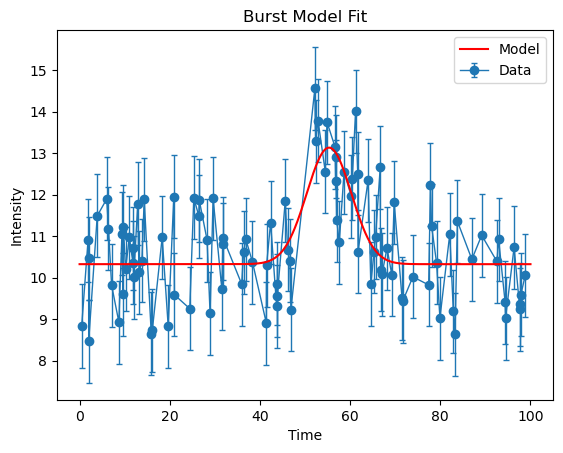

In [79]:
x = np.linspace(0, 100, 1000)
y = gaussian_graph(x, post_t0, post_b, post_A, post_sigma)
plt.plot(x, y, label="Model", color="red", zorder=3)
plt.errorbar(tt_array[..., 0], tt_array[..., 1], tt_array[..., 2], marker='o', linewidth=1, capsize=2, label="Data")
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.title("Burst Model Fit")
plt.legend()
plt.show()